# stock_kmeans

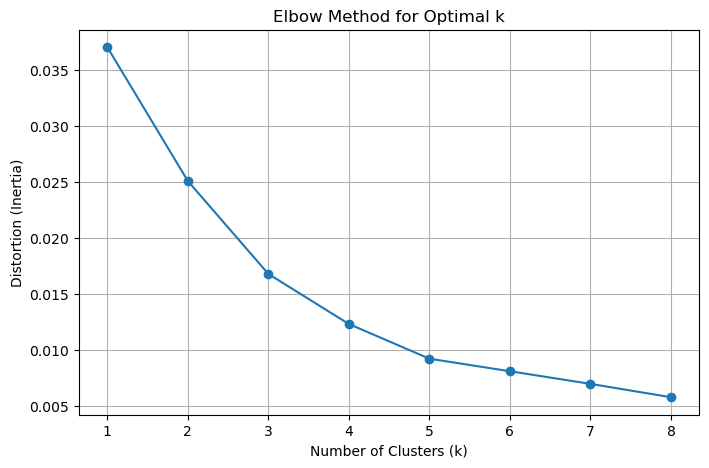

1) Optimal number of clusters: 3
2) Cluster Composition:
label       Green       Red
Cluster                    
0        0.269231  0.730769
1        1.000000  0.000000
2        0.204545  0.795455
3)Pure Clusters:
label    Green  Red
Cluster            
1          1.0  0.0


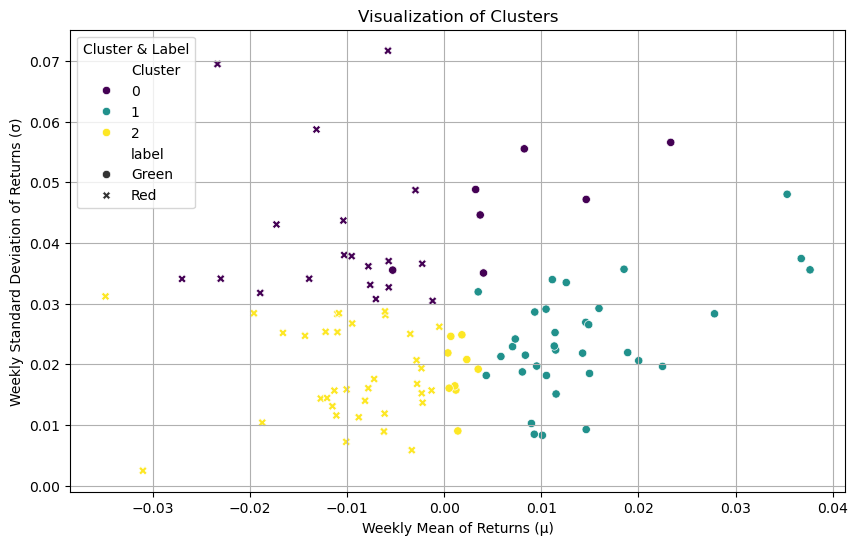

In [9]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# Load the data
data = pd.read_csv('AAL.csv')

# Parse date and extract year
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year

# Filter Year 1 and Year 2 data
year1_data = data[data['Year'] == 2022]
year2_data = data[data['Year'] == 2023]

# Calculate weekly mean and standard deviation for features
def calculate_weekly_features(df):
    weekly_features = df.groupby('Year_Week').agg(
        weekly_mean=('Return', 'mean'),
        weekly_std=('Return', 'std'),
        label=('Label', 'last')  # Use the label from the last day of the week
    ).reset_index()
    return weekly_features

year1_features = calculate_weekly_features(year1_data)
year2_features = calculate_weekly_features(year2_data)

# Combine Year 1 and Year 2 features for clustering
combined_features = pd.concat([year1_features, year2_features], ignore_index=True)
X = combined_features[['weekly_mean', 'weekly_std']]

# Question 1: Elbow method to determine the optimal k
distortions = []
silhouette_scores = []
k_range = range(1, 9)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)
    if k > 1:
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Plot the distortion vs. k
plt.figure(figsize=(8, 5))
plt.plot(k_range, distortions, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Distortion (Inertia)")
plt.grid()
plt.show()

# Determine optimal k using the "knee" method
optimal_k = 3  # Based on visual inspection from the elbow plot
print(f"1) Optimal number of clusters: {optimal_k}")

# Question 2: Apply k-means clustering and compute cluster composition
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
combined_features['Cluster'] = kmeans.fit_predict(X)

# Calculate the percentage of "Green" and "Red" weeks in each cluster
cluster_composition = combined_features.groupby('Cluster')['label'].value_counts(normalize=True).unstack().fillna(0)
print("2) Cluster Composition:")
print(cluster_composition)

# Question 3: Check for "pure" clusters (clusters with >90% of one label)
pure_clusters = cluster_composition[(cluster_composition['Green'] > 0.9) | (cluster_composition['Red'] > 0.9)]
print("3)Pure Clusters:")
print(pure_clusters)

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='weekly_mean',
    y='weekly_std',
    hue='Cluster',
    palette='viridis',
    data=combined_features,
    style='label',  # Different markers for 'Green' and 'Red'
    markers={"Green": "o", "Red": "X"}
)
plt.title("Visualization of Clusters")
plt.xlabel("Weekly Mean of Returns (μ)")
plt.ylabel("Weekly Standard Deviation of Returns (σ)")
plt.legend(title="Cluster & Label")
plt.grid()
plt.show()
